In [82]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [8]:
import torch
from torch import nn
from torch.nn import functional as F

In [11]:
from functools import reduce

shape = (2, 3, 4, 5)
length = 
halving_dim = 0

x = torch.arange(0, )
y = F.glu(x)

x.shape, y.shape

RuntimeError: Halving dimension must be even, but dimension 0 is size 201

In [71]:
def qparams(x, dtype=torch.qint8):
    fmin = min(x.min(), 0)
    fmax = max(x.max(), 0)
    
    iinfo = torch.iinfo(dtype)
    qmin = iinfo.min
    qmax = iinfo.max
    
    s = (fmax - fmin) / (qmax - qmin)
    z = (qmin - fmin / s).round().clamp(qmin, qmax).to(torch.int)
    return s.item(), z.item(), dtype

def quantize(x, params=None):
    if params is None:
        params = qparams(x, torch.qint8)
    sc, zp, dtype = params
    iinfo = torch.iinfo(dtype)
    qmin = iinfo.min
    qmax = iinfo.max

    qx = (x / sc + zp).round().clamp(qmin, qmax).to(torch.int)
    return qx

def dequantize(qx, params):
    s, zp, dtype = params
    return (qx - zp) * s

def sigmoid(x):
    return 1 / (1 + (-x).exp())

In [99]:
x = torch.arange(-10, 10, 0.5).to(torch.float)
y = sigmoid(x)

# params = qparams(y, torch.quint8)
# params = tuple([params[0], 0, params[2]])
params = (0.00392156862745098, 0, torch.quint8)
qy = quantize(y, params)
dqy = dequantize(qy, params)

print(params)
print(qy)

(0.00392156862745098, 0, torch.quint8)
tensor([  0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   2,   3,   5,   7,
         12,  19,  30,  47,  69,  96, 127, 159, 186, 208, 225, 236, 243, 248,
        250, 252, 253, 254, 254, 255, 255, 255, 255, 255, 255, 255],
       dtype=torch.int32)


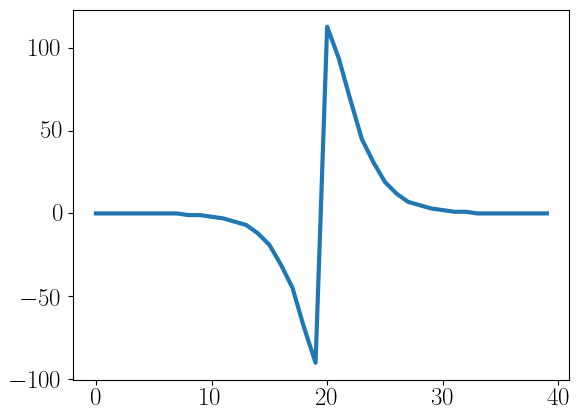

In [117]:
def qsigmoid(qx, qx_params):
    qx_s, qx_zp, qx_dtype = qx_params
    s, zp, dtype = (0.00392156862745098, 0, torch.quint8)
    
    e_s = np.exp(qx_s)
    e_sz = e_s ** qx_zp
    
    s_inv = 1.0 / s
    
    return s_inv / (1.0 + e_sz * e_qx)

qx_qparams = qparams(x, torch.qint8)
qx = quantize(x, qx_qparams)
dqx = dequantize(qx, qx_qparams)

y_ref = sigmoid(dqx)
qy_ref = quantize(y_ref, (0.00392156862745098, 0, torch.quint8))
qy = qsigmoid(qx, qx_qparams)



plt.plot(qy - qy_ref)

In [107]:
np.log(1 / dequantize(1, params) - 1)

5.537334267018537